In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.optimizers import adam, rmsprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


train = pd.read_csv('../input/Kannada-MNIST/train.csv')

Y_train = np.array(train['label'])
X_train = train.drop(['label'],1)
X_train = np.array(X_train).reshape(X_train.shape[0],28,28)
X_train = X_train.reshape(-1, 28, 28, 1)
Y_train = to_categorical(Y_train, 10)
X_train = np.array(X_train/255)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

imagegen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,
        zca_whitening=False, 
        rotation_range=9, 
        zoom_range = 0.25,
        width_shift_range=0.25,
        height_shift_range=0.25, 
        horizontal_flip=False, 
        vertical_flip=False)

imagegen.fit(x_train)

Using TensorFlow backend.


In [2]:
#CNN Solution

#Fitting Parameters
epochs = 50
batch_size = 32
lr = 0.0001
dropout = 0.40

cnn = Sequential()
cnn.add(Conv2D(filters=64, kernel_size=3, padding = 'same', activation='relu', input_shape=(28, 28, 1)))
cnn.add(Conv2D(filters=128, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=128, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Dropout(0.15))
cnn.add(MaxPooling2D(2))
cnn.add(Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Dropout(0.15))
cnn.add(MaxPooling2D(2))
cnn.add(Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Dropout(0.15))
cnn.add(MaxPooling2D(2))
#cnn.add(Conv2D(filters=1024, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(4078, activation = 'relu'))
cnn.add(Dropout(dropout))
cnn.add(Dense(4078, activation = 'relu'))
cnn.add(Dropout(dropout))
cnn.add(Dense(1000, activation = 'relu'))
cnn.add(Dropout(dropout))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=adam(lr=lr), metrics=['accuracy'])
checkpoint=ModelCheckpoint('bestweights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode="min")
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr=0.000001)
'''
hist_cnn = cnn.fit(x_train, y_train, 
                   batch_size = batch_size, 
                   epochs = epochs, 
                  verbose = 1,
                  validation_split = 0.2,
                  callbacks = [checkpoint])
'''
hist_cnn = cnn.fit_generator(imagegen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0]//64,
                             callbacks = [checkpoint, learning_rate_reduction])

cnn.load_weights("bestweights.hdf5")

Epoch 1/50
843/843 [==============================] - 32s 38ms/step - loss: 0.8108 - accuracy: 0.7038 - val_loss: 0.1020 - val_accuracy: 0.9695

Epoch 00001: val_loss improved from inf to 0.10196, saving model to bestweights.hdf5
Epoch 2/50
  5/843 [..............................] - ETA: 29s - loss: 0.2633 - accuracy: 0.9187

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


843/843 [==============================] - 31s 36ms/step - loss: 0.1445 - accuracy: 0.9555 - val_loss: 0.0415 - val_accuracy: 0.9893

Epoch 00002: val_loss improved from 0.10196 to 0.04147, saving model to bestweights.hdf5
Epoch 3/50
843/843 [==============================] - 30s 36ms/step - loss: 0.1010 - accuracy: 0.9701 - val_loss: 0.0410 - val_accuracy: 0.9900

Epoch 00003: val_loss improved from 0.04147 to 0.04104, saving model to bestweights.hdf5
Epoch 4/50
843/843 [==============================] - 30s 36ms/step - loss: 0.0872 - accuracy: 0.9745 - val_loss: 0.0247 - val_accuracy: 0.9930

Epoch 00004: val_loss improved from 0.04104 to 0.02474, saving model to bestweights.hdf5
Epoch 5/50
843/843 [==============================] - 30s 36ms/step - loss: 0.0785 - accuracy: 0.9759 - val_loss: 0.0322 - val_accuracy: 0.9913

Epoch 00005: val_loss did not improve from 0.02474
Epoch 6/50
843/843 [==============================] - 30s 35ms/step - loss: 0.0628 - accuracy: 0.9812 - val_loss:

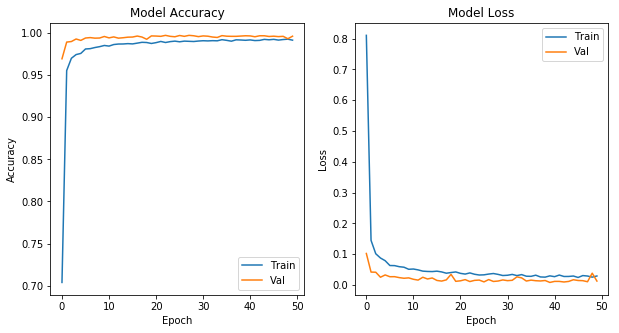

In [3]:
#graph accuracy and loss
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_size_inches(10,5)

plt.subplot(1, 2, 1)
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.show()

In [4]:
test = pd.read_csv('../input/Kannada-MNIST/test.csv')

test = test.drop(['id'],1)
x_test = np.array(test/255)
x_test = x_test.reshape(x_test.shape[0],28,28)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

results=cnn.predict(x_test)
results=np.argmax(results, axis=1)
cnn3 = pd.DataFrame({'label':results}).reset_index().rename(columns = {'index':'id'})
cnn3.to_csv('cnn3_img_aug.csv',index = False)



In [5]:
hist_cnn.history

{'val_loss': [0.10195699999729792,
  0.041468785360145075,
  0.041039643208806716,
  0.024736138640437274,
  0.032234439357804755,
  0.026409586844344933,
  0.02657739347681248,
  0.02348182527969281,
  0.02141106404858874,
  0.02266079670501252,
  0.018107843855240693,
  0.01543690459507828,
  0.024725201081096507,
  0.019073239658454744,
  0.02232695313412114,
  0.014321046712885921,
  0.012227592574539207,
  0.016209863922995282,
  0.034074586018454284,
  0.011442779568761276,
  0.013113124223649113,
  0.016980254186550154,
  0.010733985741467526,
  0.014587676905068899,
  0.01549954012016921,
  0.009632036105453153,
  0.0171945237951392,
  0.011031887404465427,
  0.012382279077280449,
  0.016011915577100203,
  0.013631642000105179,
  0.014772644454302887,
  0.025933689900023257,
  0.022697973348883353,
  0.012364520075398105,
  0.015323629881472376,
  0.013408767162414733,
  0.012600908604797345,
  0.014118953085817945,
  0.007810259744282424,
  0.011226989199708139,
  0.0112083787